In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from qutip import *
import matplotlib.gridspec as gridspec
from scipy.integrate import trapezoid
from qutip import wigner
from tqdm.auto import tqdm

# Project

Used article by Olga Solodovnikova as a reference for the implementation of GKP states and their Wigner functions.
This projects aims to reconstruct the simulations made by Olga.

## GKP states

Defined as a superposition of many squeezed vacuum states displaced by a factor of n
\
\
$ \ket{j, \Delta_x, \Delta_p} = \sum_n{ e^{-\frac{1}{2}\cdot \Delta_p^2((2n + j)\sqrt{\pi\hbar})^2}\hat{X}}(2n + j)\sqrt{\pi\hbar}\ket{\Delta_x}$

$\ket{\Delta_x}=\hat{S}(\Delta_x^{-1})\ket{0}$

First step in this project is to simulate GKP states using QuTip

In [2]:
def GKP_states(N, delta_x, delta_p, j):

    n_max = 20
    n = np.arange(-n_max, n_max+1)

    sq_operator = squeeze(N, z = np.log(1/delta_x))


    vacuum = basis(N,0)

    #first apply squeeze
    psi_0 = sq_operator * vacuum
    psi_1 = 0 * psi_0

    for i in range(len(n)):
        dis_operator = displace(N, alpha = (2*n[i]+j)*np.sqrt(np.pi))
        exponent = -0.5 * delta_p**2 * ( (2*n[i]+j) * np.sqrt(2)) **2
        psi_1 += dis_operator * psi_0 * np.exp(exponent)

    return psi_1.unit()

N_gkp=200

In [3]:
delta_x = 0.4

gkp_state_2 = squeeze(N_gkp, z = np.log(1/delta_x))* GKP_states(N_gkp, delta_x=delta_x, delta_p=delta_x, j = 0) 
gkp_state_3 = displace(N_gkp, delta_x) * GKP_states(N_gkp, delta_x=delta_x, delta_p=delta_x, j = 0) 
gkp_state_0 = GKP_states(N_gkp, delta_x=delta_x, delta_p=delta_x, j = 1) 
gkp_state_1 = GKP_states(N_gkp, delta_x=delta_x, delta_p=delta_x, j = 0)

In [4]:
x = np.linspace(-8, 8, 200)
p = np.linspace(-8, 8, 200)

W_GKP_0 = wigner(gkp_state_0, x, p)
W_GKP_1 = wigner(gkp_state_1, x, p)
W_GKP_2 = wigner(gkp_state_2, x, p)
W_GKP_3 = wigner(gkp_state_3, x, p)

vmin = min(W_GKP_0.min(), W_GKP_1.min(), W_GKP_2.min(), W_GKP_3.min())
vmax = max(W_GKP_0.max(), W_GKP_1.max(), W_GKP_2.max(), W_GKP_3.max())

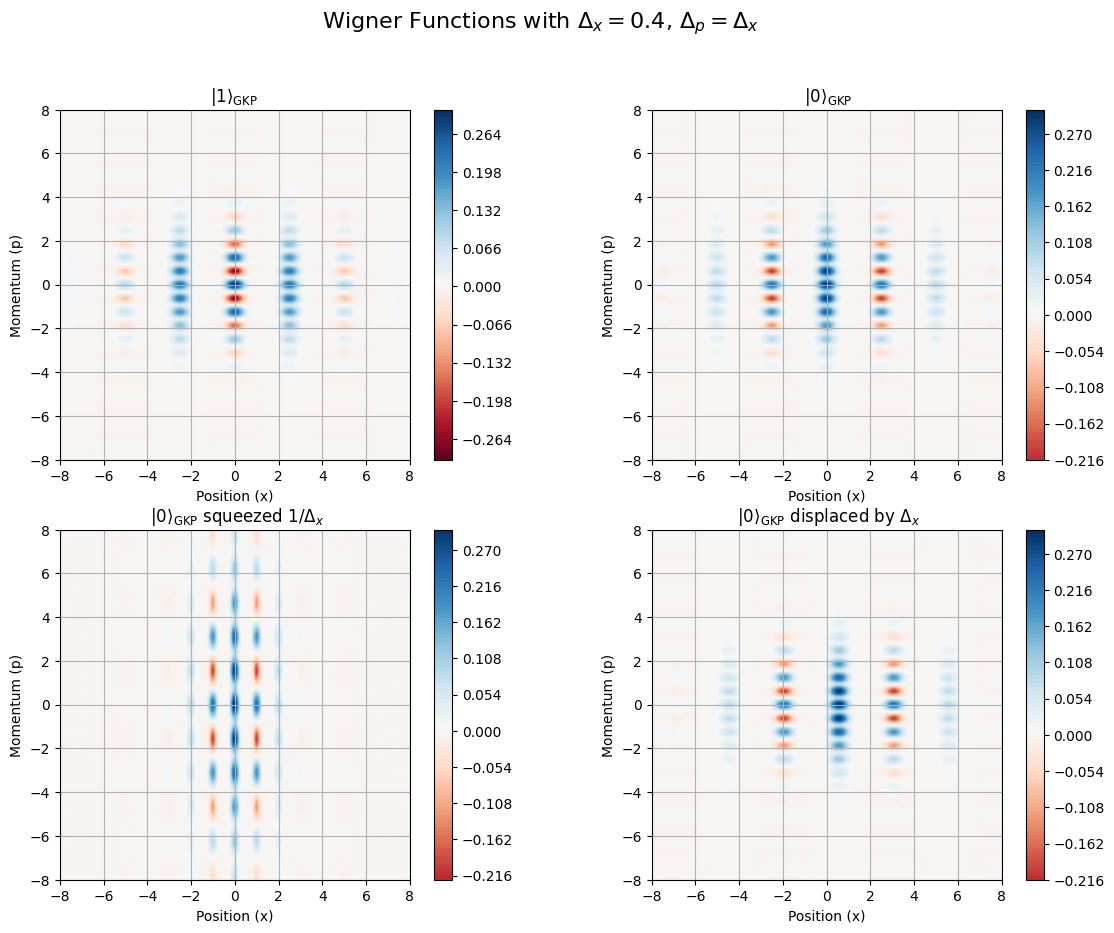

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plt.suptitle(r"Wigner Functions with $\Delta_x=0.4$, $\Delta_p=\Delta_x$", fontsize=16)

cf1 = axs[0,0].contourf(x, p, W_GKP_0, levels=100, cmap='RdBu', vmin=vmin, vmax=vmax)
axs[0,0].set_xlabel("Position (x)")
axs[0,0].set_ylabel("Momentum (p)")
axs[0,0].set_title(r"$|1\rangle_{\rm GKP}$ ")
axs[0,0].set_aspect('equal')
axs[0,0].grid()
fig.colorbar(cf1, ax=axs[0,0])

cf2 = axs[0,1].contourf(x, p, W_GKP_1, levels=100, cmap='RdBu', vmin=vmin, vmax=vmax)
axs[0,1].set_title(r" $|0\rangle_{\rm GKP}$ ")
axs[0,1].set_xlabel("Position (x)")
axs[0,1].set_ylabel("Momentum (p)")
axs[0,1].set_aspect('equal')
axs[0,1].grid()
fig.colorbar(cf2, ax=axs[0,1])

cf3 = axs[1,0].contourf(x, p, W_GKP_2, levels=100, cmap='RdBu', vmin=vmin, vmax=vmax)
axs[1,0].set_title(r" $|0\rangle_{\rm GKP}$ squeezed $1/\Delta_x$")
axs[1,0].set_xlabel("Position (x)")
axs[1,0].set_ylabel("Momentum (p)")
axs[1,0].set_aspect('equal')
axs[1,0].grid()
fig.colorbar(cf3, ax=axs[1,0])

cf4 = axs[1,1].contourf(x, p, W_GKP_3, levels=100, cmap='RdBu', vmin=vmin, vmax=vmax)
axs[1,1].set_title(r" $|0\rangle_{\rm GKP}$ displaced by $\Delta_x$ ")
axs[1,1].set_xlabel("Position (x)")
axs[1,1].set_ylabel("Momentum (p)")
axs[1,1].set_aspect('equal')
axs[1,1].grid()
fig.colorbar(cf4, ax=axs[1,1])

plt.show()

In the plot above we have the wignerfunction of different GKP states. The hope it our simulations will create one of these Wignerfunctions later. In the code below, the plots which Olga has made have been created analytically.

### $\tilde{f}(p1,p2) = 2e^{(i\mu \sqrt{2/3} \cdot p2 \cdot / \hbar)} \cos(\mu \sqrt{2} p1 / \hbar) \cdot e^{(-i\mu \sqrt{2/3} \cdot p2 \cdot / \hbar)}$

Where p1 and p2 are the projection after first and second beamsplitters, respectively.

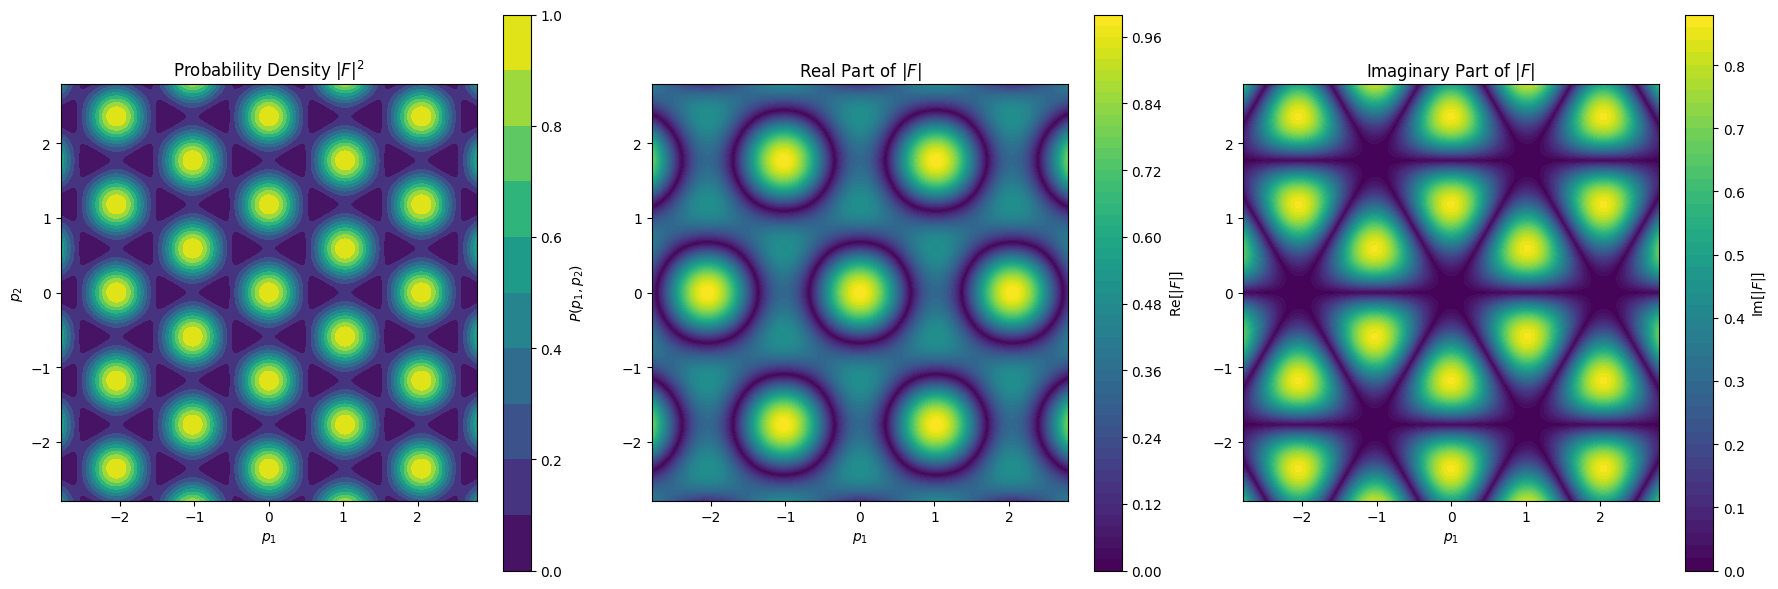

In [6]:

# Parameters
hbar = 1
r = 0.2
mu = np.sqrt(3 * np.pi * hbar / 2)  # For qunaught state
#sigma_sq = (hbar / 2) * np.exp(2 * r)  # Variance of p-quadrature

p1_range = np.linspace(-7,7, 200) * 1/np.sqrt(2*np.pi)
p2_range = np.linspace(-7,7, 200)  * 1/np.sqrt(2*np.pi)
P1, P2 = np.meshgrid(p1_range, p2_range)

def f1(p1, p2):
    term1 = 2 * np.exp(1j * mu * np.sqrt(2/3) * p2 / hbar) * np.cos(mu * np.sqrt(2) * p1 / hbar)
    term2 = np.exp(-1j * mu * 2 * np.sqrt(2/3) * p2 / hbar)
    return (term1 + term2) / 3  # Normalized to max=1 at p1=p2=0

F = f1(P1, P2)

F_im = np.imag(F)
F_real = np.real(F)
P = np.abs(F)**2


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# |F|² (Probability density)
contour1 = axes[0].contourf(P1, P2, P, levels=np.linspace(0, 1, 11), cmap='viridis')
fig.colorbar(contour1, ax=axes[0], label='$P(p_1, p_2)$')
axes[0].set_title('Probability Density $|F|^2$')
axes[0].set_xlabel('$p_1$')
axes[0].set_ylabel('$p_2$')
axes[0].set_aspect('equal')

# Re(F)
contour2 = axes[1].contourf(P1, P2, abs(F_real), levels=50, cmap='viridis')
fig.colorbar(contour2, ax=axes[1], label='Re[$|F|$]')
axes[1].set_title('Real Part of $|F|$')
axes[1].set_xlabel('$p_1$')
axes[1].set_aspect('equal')

# Im(F)
contour3 = axes[2].contourf(P1, P2, abs(F_im), levels=50, cmap='viridis')
fig.colorbar(contour3, ax=axes[2], label='Im[$|F|$]')
axes[2].set_title('Imaginary Part of $|F|$')
axes[2].set_xlabel('$p_1$')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

$\tilde{f}(p1,p2) = 2e^{(i\mu \sqrt{2/3} \cdot p2 \cdot / \hbar)} \cos(\mu \sqrt{2} p1 / \hbar) \cdot e^{(-i\mu \sqrt{2/3} \cdot p2 \cdot / \hbar)}$


The wish is to create the following plot where the colors indicate $\Delta_p$, which we didnt simulate analytically.


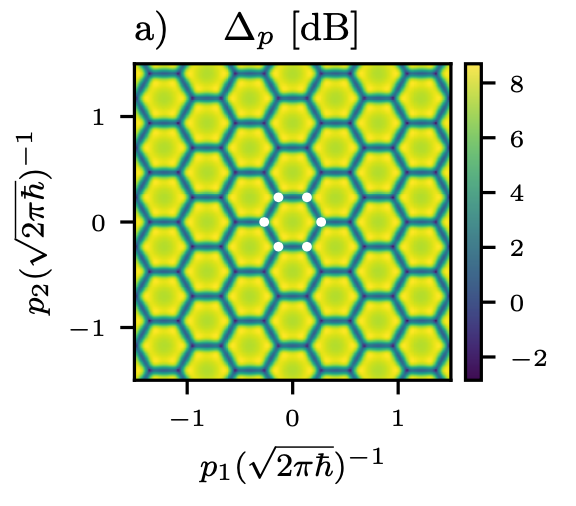

## Squeezed cat state

$|\psi_k\rangle = S(e^r)(| \alpha \rangle + (-)^k | -\alpha \rangle) $, where k is the parity 

$\hat{\rho_k} = |\psi_k\rangle\langle\psi_k|$

Next goal is to create the beam splitter cascade as shown in the figure, where the input is a density matrix of cat states, to create the simulation above. To create the plot above, only two beamsplitters are needed, N = 3.


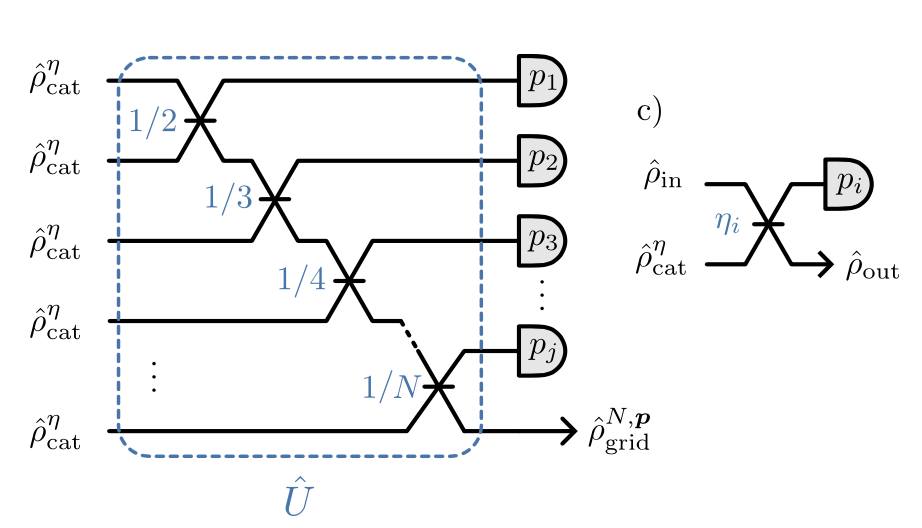

The cat states get created

In [7]:
N = 20 #Hilbert space cutoff per mode¨

cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1)).unit()

sq = squeeze(N, z = np.log(1.2))

cat_state_squeezed = (sq * cat_state).unit()

x = np.linspace(-5, 5, 100)

p = np.linspace(-5, 5, 100)

cat_W = wigner(cat_state_squeezed, x, p)

Input in beamsplitter: $\hat{\rho_1}  \otimes \hat{\rho_2} $

In [8]:
two_mode_cat_begin = tensor(cat_state_squeezed, cat_state_squeezed)


Creating a function for the Beamsplitter

$BS(\theta) \hat{\rho_1}  \otimes \hat{\rho_2}$

In [9]:
def BS(T, N1, N2, input_state):
    """
    Beam splitter operator with transmissivity eta.
    Works on density matrices only.
    """

    a1, a2 = destroy(N1), destroy(N2)

    # angle from transmissivity
    eta = 1/T
    theta = np.arccos(np.sqrt(eta))

    # quadratures
    x1 = (a1 + a1.dag()) / np.sqrt(2)
    p1 = 1j * (a1.dag() - a1) / np.sqrt(2)
    x2 = (a2 + a2.dag()) / np.sqrt(2)
    p2 = 1j * (a2.dag() - a2) / np.sqrt(2)

    # BS generator
    H_BS = 1j * theta * (tensor(p1, x2) - tensor(x1, p2))
    U_BS = H_BS.expm()

    if input_state.isket:
        input_state = input_state * input_state.dag()

    out_put = U_BS * input_state * U_BS.dag()

    return out_put  # normalize


In [10]:
#cat_out_mode1and2 = BS(2, N, N, two_mode_cat_begin)
#wigner_ = wigner(cat_out_mode1and2, x, p)
#plt.contour(wigner_, levels=1000)

So now I have a two-mode squeezed cat state after the beam splitter. 

It is needed to do a measurement on mode 1 by projecting it onto a P-state.

I am assuming the P output is 0, which is a squeezed vacuum state, since our fockspace not can be infinite-dimensional.
Not assuming P is 0, could lead to displacement issues later in the cascade.

To simulate a P state which is zero. A vaccum state has been squeezed as much as the fockspace allows for a given size of the Hilbert–space.

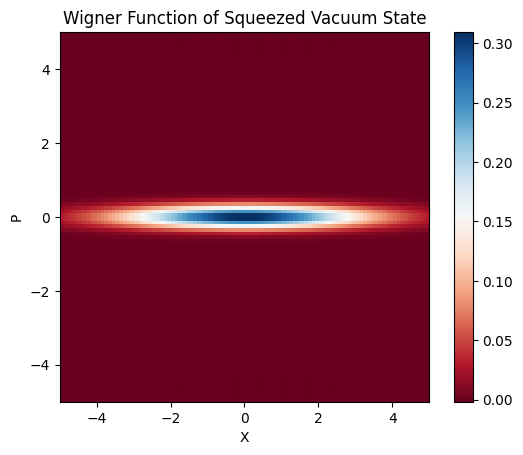

In [63]:
vac = basis(N, 0)
r_vac = -1.2
vac_squeezed =  squeeze(N, z = r_vac) * vac.unit()

vac_wigner = wigner(vac_squeezed,x,p)
plt.figure()
plt.imshow(vac_wigner, extent=[-5, 5, -5, 5], cmap='RdBu')
plt.title('Wigner Function of Squeezed Vacuum State')
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.show()

Plotting the fock distribution to verify.

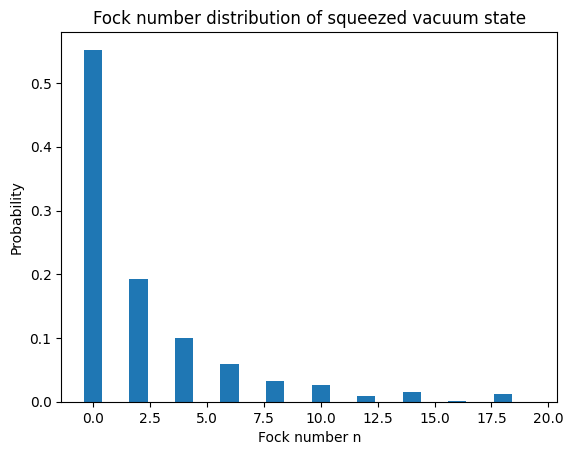

In [12]:
n = np.arange(N)  # Fock numbers
probs = np.abs(vac_squeezed.full())**2  # |<n|psi>|^2
probs = probs.flatten() 
plt.bar(n, probs)
plt.xlabel("Fock number n")
plt.ylabel("Probability")
plt.title("Fock number distribution of squeezed vacuum state")
plt.show()

$H_{space} = H_{mode 1} \otimes H_{mode 2} => $ all modes must have $N^2$ dimensions 

## Cat Breeding
Next part is to simulate the cascade, in the following code the beamsplitting can be done up to N times, however only by a projection onto squeezed vacuum in p.

In [ ]:
def cat_breeding(eta_list, N): 
    # vacuum projector on mode 2
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z=-1.2) * vac

    vac_DM = vac_squeezed * vac_squeezed.dag()

    vac_DM_full = tensor(qeye(N), vac_DM)

    # initial cat state
    alpha = 6.11
    cat_state = (coherent(N, alpha) + coherent(N, -alpha)).unit()
    #mu = np.sqrt(3/2 * np.pi)
    sq = squeeze(N, z=np.log(10**-1.2)/-2)
    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    # lists to save states
    mode_1_list, mode_2_list = [], []

    current_state = cat_DM  # always density matrix

    for t in eta_list:
        # always tensor density matrices
        two_mode = tensor( cat_DM,current_state)

        # apply BS
        cat_out = BS(t, N, N, two_mode)

        # project mode 1 onto squeezed vacuum
        projected1 = (vac_DM_full * cat_out * vac_DM_full.dag()).ptrace(0)
        #projected2 = (vac_DM_full * cat_out * vac_DM_full.dag()).ptrace(1)

        # normalize
        projected1 = projected1 / projected1.tr()
        #projected2 = projected2 / projected2.tr()

        # update for next step
        current_state = projected1
        mode_1_list.append(projected1)
        #mode_2_list.append(projected2)

    return mode_1_list#, mode_2_list


In [15]:
eta_list = np.arange(2,4)
cat_1mode, _ = cat_breeding(eta_list, N=20)

wigner_cat1 = []
wigner_cat2 = []

x = np.linspace(-5, 5, 100)#/np.sqrt(np.pi*2)
p = np.linspace(-5, 5, 100)#/np.sqrt(np.pi*2)

for i in tqdm(range(len(eta_list)), desc="Computing Wigner functions", unit="iterations"):
        wigner_cat1.append(wigner(cat_1mode[i], x, p))
        #wigner_cat2.append(wigner(cat_2mode[i], x, p))  

Computing Wigner functions:   0%|          | 0/2 [00:00<?, ?iterations/s]

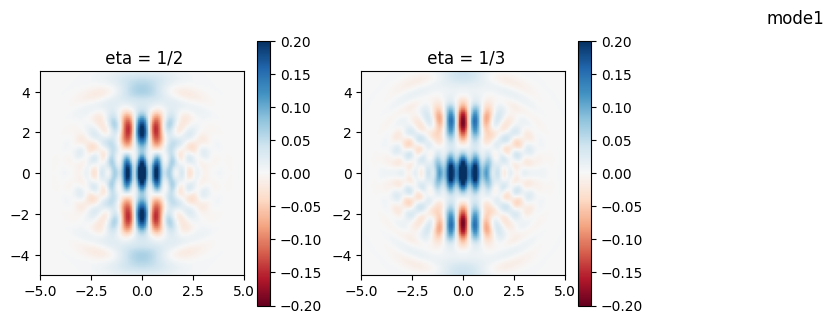

IndexError: list index out of range

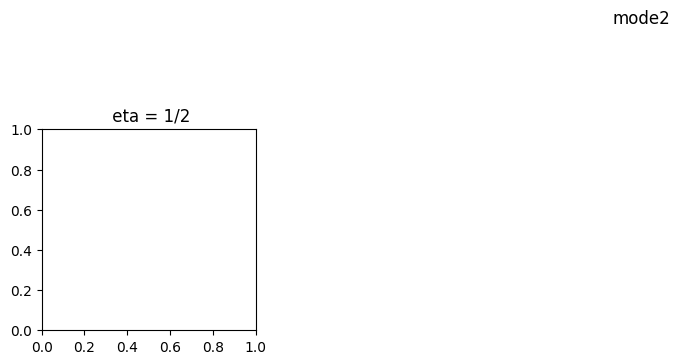

In [16]:
plt.figure(figsize=(16, 12))
plt.suptitle('mode1')

for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f" eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat1[i], extent=[-5, 5, -5, 5], vmin = -0.2, vmax = 0.2, cmap='RdBu')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
plt.suptitle('mode2')
for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f" eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat2[i], extent=[-5, 5, -5, 5], vmin = -0.2, vmax = 0.2, cmap='RdBu')
    plt.colorbar()
plt.tight_layout()
plt.show()

Checks the probability for even and uneven N

In [ ]:
"""P_x_list = [np.trapezoid(wigner_cat1[i], x, axis=0) for i in range(len(wigner_cat1))]


for i in range(len(wigner_cat1)):
    if i%2 == 0:
        plt.plot(x, P_x_list[i], color ='red',label=f"eta = 1/{eta_list[i]}")
    elif i%2 == 1:
        plt.plot(x, P_x_list[i], color ='blue',label=f"eta = 1/{eta_list[i]}")
plt.xlabel('$x$')
plt.ylabel('$P(x)$')
plt.title('Probability distribution for even and odd N')
plt.legend()
plt.grid()
plt.show()"""

'P_x_list = [np.trapezoid(wigner_cat1[i], x, axis=0) for i in range(len(wigner_cat1))]\n\n\nfor i in range(len(wigner_cat1)):\n    if i%2 == 0:\n        plt.plot(x, P_x_list[i], color =\'red\',label=f"eta = 1/{eta_list[i]}")\n    elif i%2 == 1:\n        plt.plot(x, P_x_list[i], color =\'blue\',label=f"eta = 1/{eta_list[i]}")\nplt.xlabel(\'$x$\')\nplt.ylabel(\'$P(x)$\')\nplt.title(\'Probability distribution for even and odd N\')\nplt.legend()\nplt.grid()\nplt.show()'

### $\mu = \sqrt{(3\cdot \pi/2)}$ defined in the article 

### $r = ln(10^{-1.2}/-2)$
### $\mu = \sqrt{2}  \alpha \cdot  e^{-r} $ to find $\alpha$ for $|\psi_k\rangle$.

### $\alpha = \frac{\pi}{\sqrt{2}} (\kappa + i\cdot \kappa)$

To calculate $\Delta_p$ for different projections onto p1 and p2, other formulas are needed

## $\Delta_p = \sqrt{\frac{-2}{|\alpha|^2}\cdot \ln{|\langle \hat{D}(\alpha)\rangle|}}$

## $\chi_{\hat{\rho_k}} = \langle \hat{D}(\alpha) \rangle = Tr[ \hat{\rho_k}\hat{D}(\alpha)]$

Defining a function for $\Delta_p$

In [17]:
mu = np.sqrt(3*np.pi /2)

# mu = np.sqrt(2) * alpha * exp(-r)

r = np.log(10**-1.2)/-2
alpha = mu / (np.sqrt(2) * np.exp(-r))

def Dp(rho,N):

    kappa_plus = 1/(3**(1/4)) + (3)**(1/4)
    kappa_minus = 1/(3**(1/4)) - (3)**(1/4)

    alpha_dis = np.sqrt(np.pi/2)*(kappa_plus + 1j*kappa_minus)

    displace_ = displace(N, alpha_dis)
    chi = (rho * displace_ ).tr()

    Dp_ = np.sqrt( - 2 / (abs(alpha_dis)**2) * np.log(abs(chi)))
    return Dp_

## Creating a cat breeding circuit which only goes up to N = 3, however can take p1 and p2 as inputs.

In [18]:
def cat_breeding_N3(N,p1,p2):

    # vacuum projector on mode 2
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z=-1.2) * vac

    p1_dis = displace(N,p1)
    p2_dis = displace(N,p2)

    vac_dis1 = p1_dis * vac_squeezed
    vac_dis2 = p2_dis * vac_squeezed

    vac_1_DM = vac_dis1 * vac_dis1.dag()
    vac_2_DM = vac_dis2 * vac_dis2.dag()

    vac_full_1 = tensor(qeye(N), vac_1_DM)
    vac_full_2 = tensor(qeye(N), vac_2_DM)

    # initial cat state
    alpha = 6.11
    cat_state = (coherent(N, alpha) + coherent(N, -alpha)).unit()
    sq = squeeze(N, z=np.log(10**-1.2)/-2)
    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    mode_1_list, mode_2_list = [], []
    current_state = cat_DM

    # === Step 1 (eta = 2) ===
    two_mode = tensor(cat_DM,current_state)
    cat_out = BS(2, N, N, two_mode)
    projected_step1_BS1 = (vac_full_1 * cat_out * vac_full_1.dag()).ptrace(0)
    #projected_step2_BS1 = (vac_full_2 * cat_out * vac_full_2.dag()).ptrace(1)
    projected_step1_BS1 /= projected_step1_BS1.tr()
    #projected_step2_BS1 /= projected_step2_BS1.tr()
    
    #mode_1_list.append(projected1)
    #mode_2_list.append(projected2)

    # === Step 2 (eta = 3) ===
    two_mode_new = tensor(cat_DM,projected_step1_BS1)
    cat_out = BS(3, N, N, two_mode_new)
    
    projected_step1_BS2 = (vac_full_1 * cat_out * vac_full_1.dag()).ptrace(0)
    #projected_step2_BS2 = (vac_full_2 * cat_out * vac_full_2.dag()).ptrace(1)
    projected_step1_BS2 /= projected_step1_BS2.tr()
    #projected_step2_BS2 /= projected_step2_BS2.tr()

    return projected_step1_BS2#, projected_step2_BS2


In [64]:
def cat_breeding_N3(N,p1,p2):

    # vacuum projector on mode 2
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z=-1.2) * vac

    p1_dis = displace(N,p1*1j)
    p2_dis = displace(N,p2*1j)

    vac_dis1 = p1_dis * vac_squeezed
    vac_dis2 = p2_dis * vac_squeezed

    vac_1_DM = vac_dis1 * vac_dis1.dag()
    vac_2_DM = vac_dis2 * vac_dis2.dag()

    vac_full_1 = tensor(qeye(N), vac_1_DM)
    vac_full_2 = tensor(qeye(N), vac_2_DM)

    # initial cat state
    alpha = 6.11
    cat_state = (coherent(N, alpha) + coherent(N, -alpha)).unit()
    sq = squeeze(N, z=np.log(10**-1.2)/-2)
    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    mode_1_list, mode_2_list = [], []
    current_state = cat_DM

    # === Step 1 (eta = 2) ===
    two_mode = tensor(cat_DM,current_state)
    cat_out = BS(2, N, N, two_mode)
    projected_step1_BS1 = (vac_full_1 * cat_out * vac_full_1.dag()).ptrace(0)
    projected_step2_BS1 = (vac_full_1 * cat_out * vac_full_1.dag()).ptrace(1)
    projected_step1_BS1 /= projected_step1_BS1.tr()
    projected_step2_BS1 /= projected_step2_BS1.tr()
    
    #mode_1_list.append(projected1)
    #mode_2_list.append(projected2)

    # === Step 2 (eta = 3) ===
    two_mode_new = tensor(cat_DM,projected_step1_BS1)
    cat_out = BS(3, N, N, two_mode_new)
    
    projected_step1_BS2 = (vac_full_2 * cat_out * vac_full_2.dag()).ptrace(0)
    projected_step2_BS2 = (vac_full_2 * cat_out * vac_full_2.dag()).ptrace(1)
    projected_step1_BS2 /= projected_step1_BS2.tr()
    projected_step2_BS2 /= projected_step2_BS2.tr()

    return projected_step1_BS2, projected_step2_BS2


## Testing out for $\eta = 1/3$ and plotting wigner 

In [80]:
eta_list = np.arange(2,4)

N = 40

p1, p2 = 0.25*np.sqrt(2*np.pi), 0

cat_2modeN3, cat_1modeN3 = cat_breeding_N3(N,p1,p2)
#cat_1mode, cat_2mode = cat_breeding(eta_list, N)

x = np.linspace(-5, 5, 100)#/np.sqrt(np.pi*2)
p = np.linspace(-5, 5, 100)#/np.sqrt(np.pi*2)

#for i in tqdm(range(len(eta_list)), desc="Computing Wigner functions", unit="iterations"):
        
        #wigner_cat1.append(wigner(cat_1mode[i], x, p))

wigner_cat1N3 = wigner(cat_1modeN3, x, p)
wigner_cat2N3 = wigner(cat_2modeN3, x, p)

In [84]:
print(40*50*50/60)

1666.6666666666667


Finding the probability distribution for p and x

In [81]:
Px_0 = np.trapezoid(wigner_cat2N3, p, axis=0)  
Pp_0 = np.trapezoid(wigner_cat2N3, x, axis=1)

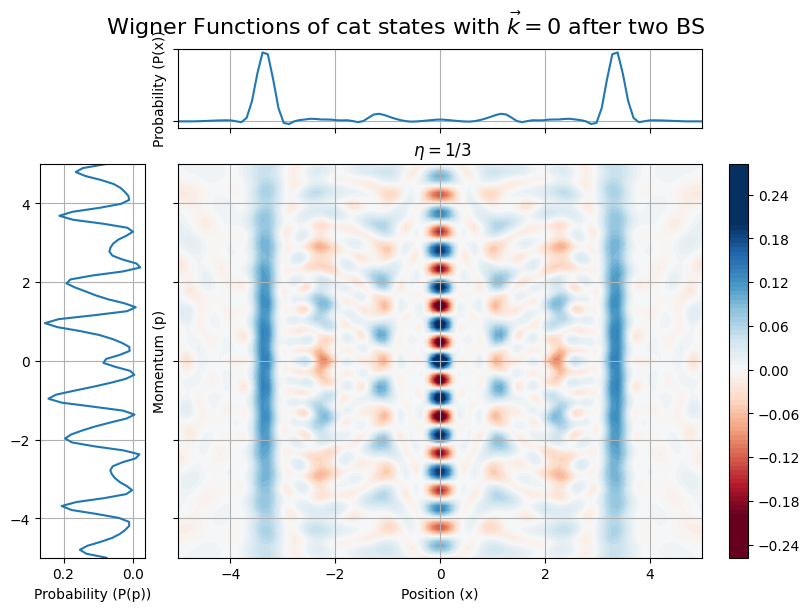

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True, gridspec_kw={"height_ratios": [0.2, 1], "width_ratios": [0.2, 1]}, sharex = "col", sharey = "row")

plt.suptitle(r"Wigner Functions of cat states with $\vec{k} = 0$ after two BS", fontsize=16)

axs[0, 1].plot(x,Px_0)
axs[0, 1].set_ylabel("Probability (P(x))")
axs[0,1].grid()

axs[0, 0].axis('off')  # disables axes for this cell

cf3 = axs[1,1].contourf(x, p, wigner_cat2N3, levels=100,  vmin = -0.2, vmax = 0.2, cmap = 'RdBu')

axs[1,1].set_title(r" $\eta = 1/3$")
axs[1,1].set_xlabel("Position (x)")
axs[1,1].set_ylabel("Momentum (p)")
axs[1,1].grid()
fig.colorbar(cf3, ax=axs[1,1], location = 'right', shrink = 1)

axs[1, 0].plot(Pp_0,p)
axs[1,0].invert_xaxis()
axs[1, 0].set_xlabel("Probability (P(p))")
axs[1, 0].grid()

# Olgas plot
 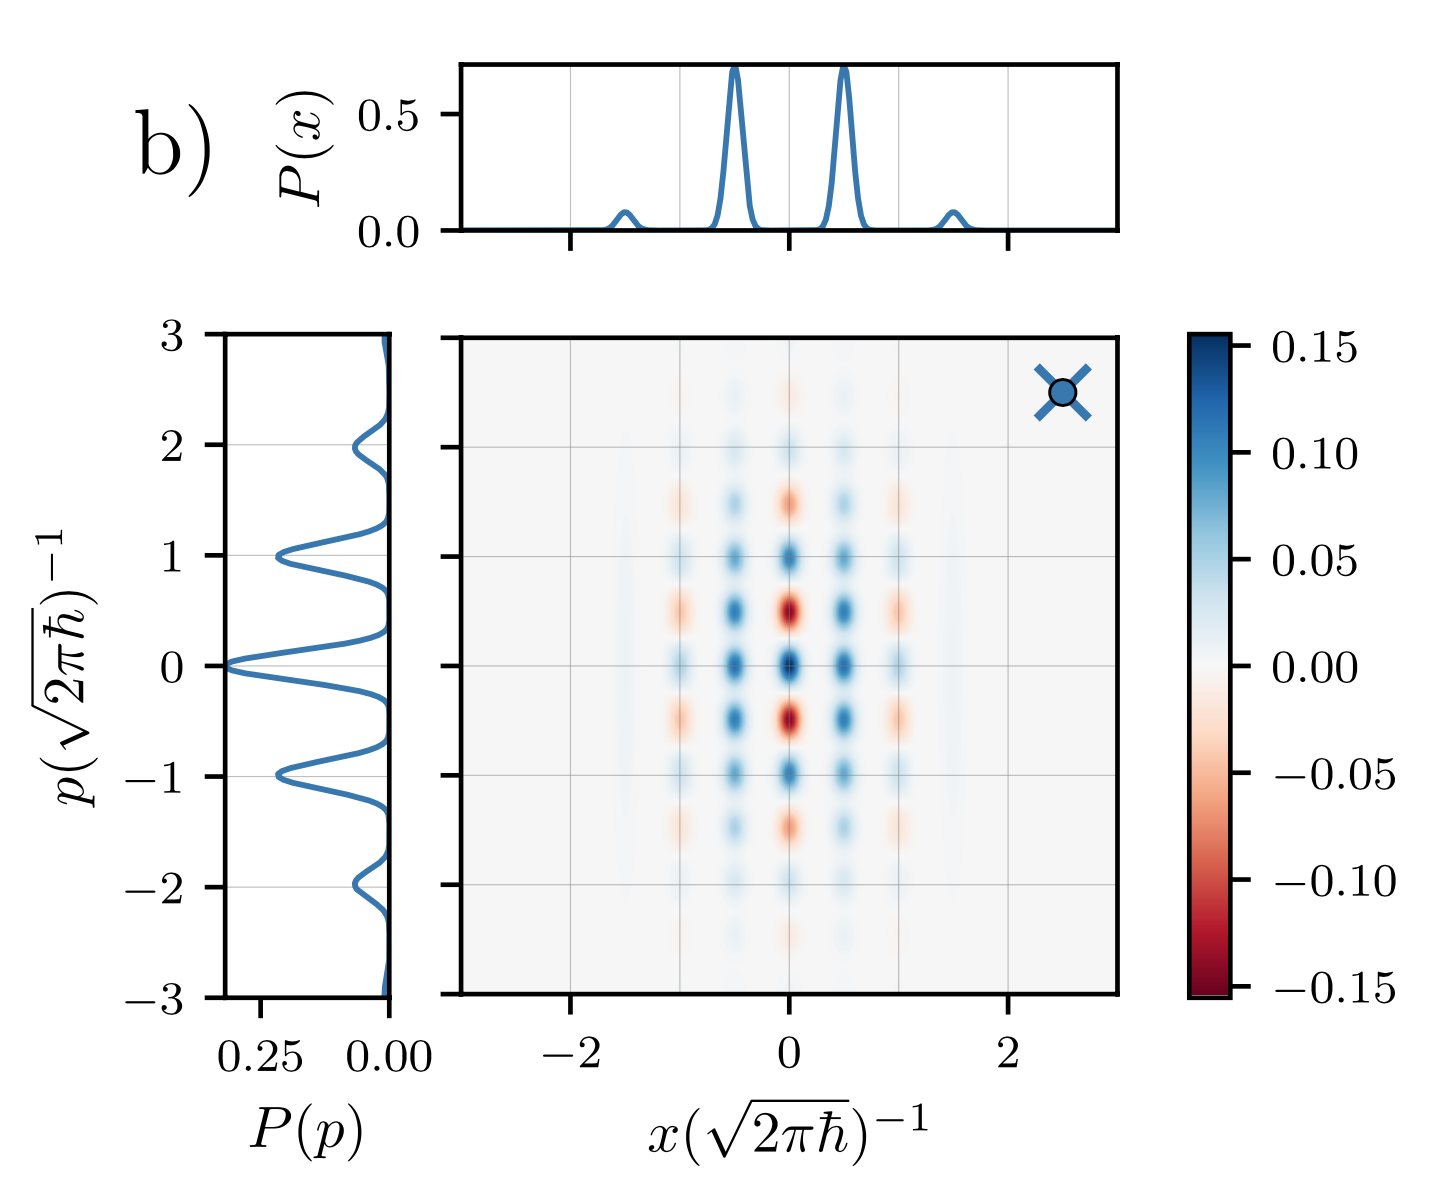

## Creating the final simulation from the Article !!!!

Problem, seems like the Wigner function doesnt really change depending on p1 and p2

In [87]:
p1_list = np.linspace(-0.7, 0.7, 10)
p2_list = np.linspace(-0.7, 0.7, 10)

mode1_mesh = np.zeros((len(p1_list), len(p2_list)), dtype=float)
rho = []

N = 40

rho = np.empty((len(p1_list), len(p2_list)), dtype=object)

for i, p1 in enumerate(tqdm(p1_list, desc="p1 loop")):
    for j, p2 in enumerate(tqdm(p2_list, desc="p2 loop", leave=False)):
        rho_final, _ = cat_breeding_N3(N, p1, p2)
        rho[i, j] = rho_final    # directly index it
        mode1_mesh[i, j] = Dp(rho_final, N)



p1 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

p2 loop:   0%|          | 0/10 [00:00<?, ?it/s]

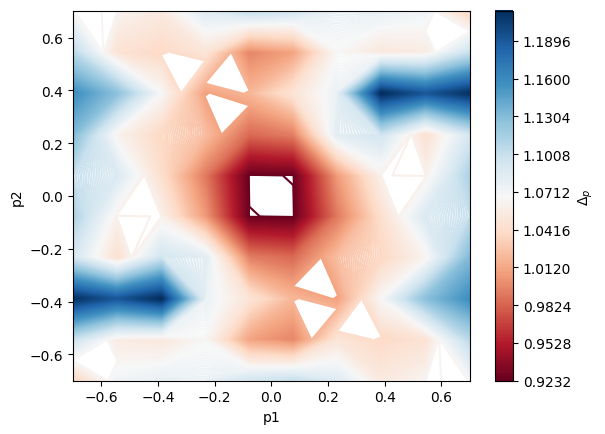

In [89]:
P1, P2 = np.meshgrid(p1_list, p2_list, indexing='ij')  # 'ij' keeps same shape as mode1_mesh
    
plt.contour(p2_list, p1_list, mode1_mesh,levels = 400,cmap='RdBu')
plt.xlabel('p1')
plt.ylabel('p2')
plt.colorbar(label=r'$\Delta_p$')
plt.show()

Sanity check

In [45]:
wign_random1= wigner(rho[0,0],x,p)
wign_random2= wigner(rho[15,4],x,p)

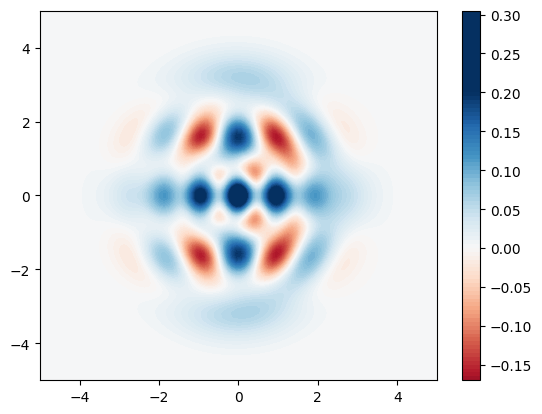

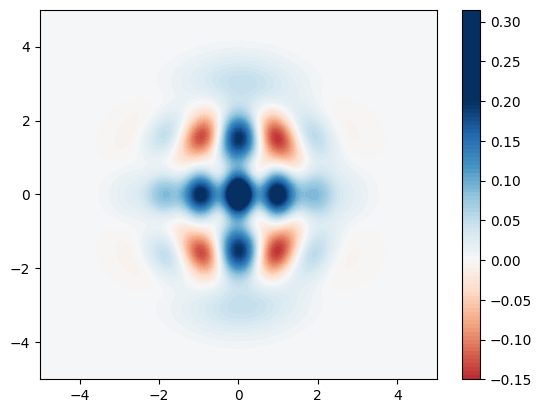

In [46]:
plt.contourf(x, p, wign_random1, levels=100, vmin = -0.2, vmax = 0.2, cmap = 'RdBu')
plt.colorbar()
plt.show()
plt.contourf(x, p, wign_random2, levels=100, vmin = -0.2, vmax = 0.2, cmap = 'RdBu')
plt.colorbar()
plt.show()

## Pretty Quantum Plots, however completely unphysical

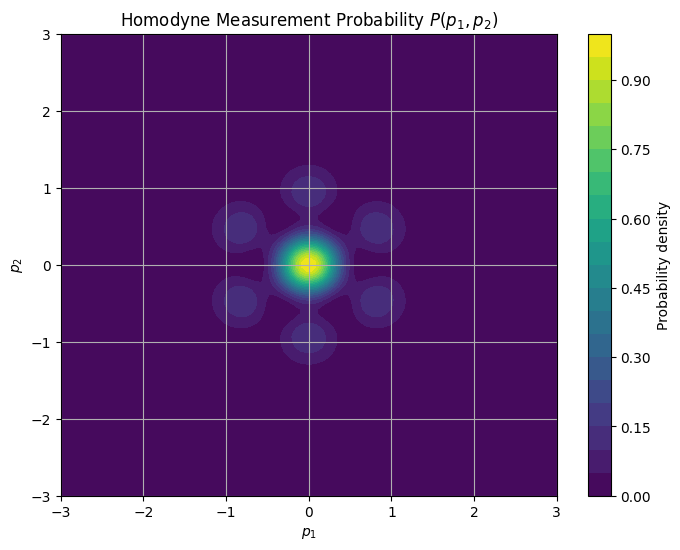

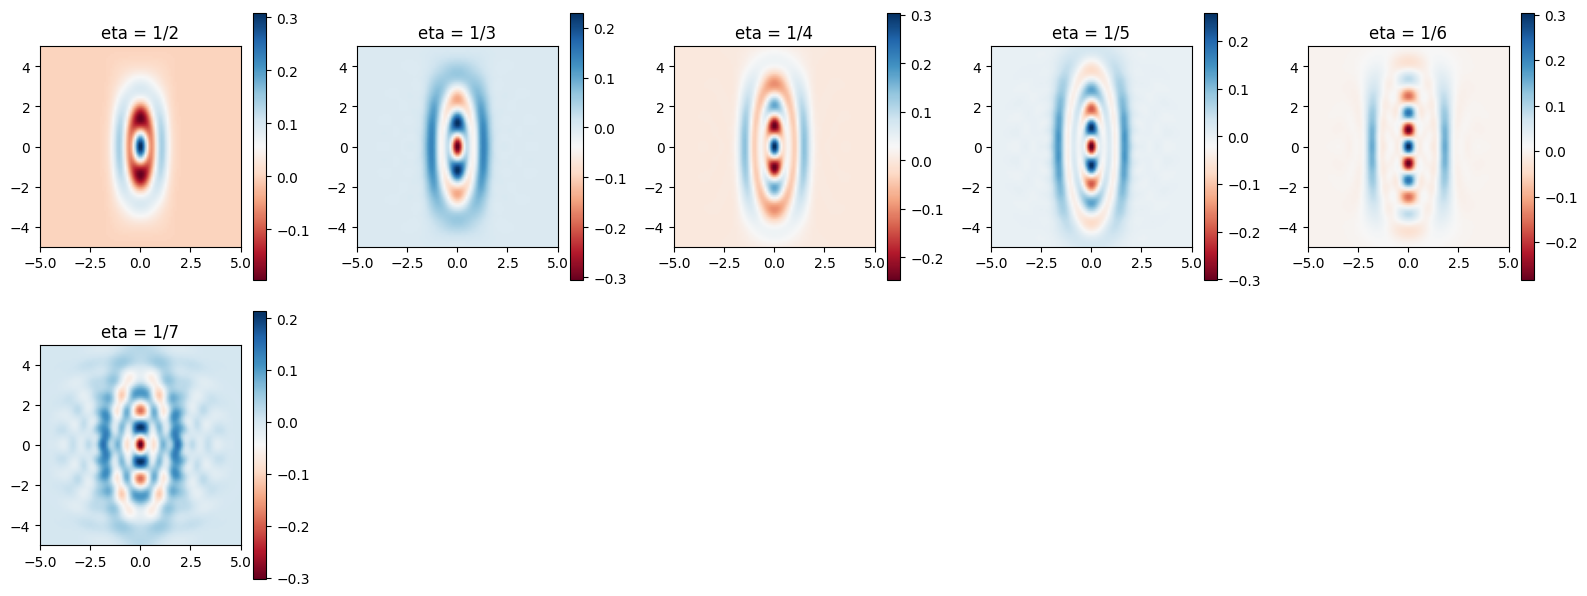

# N waaaay to small

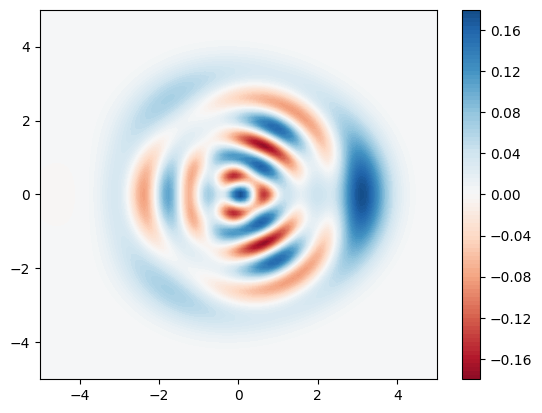


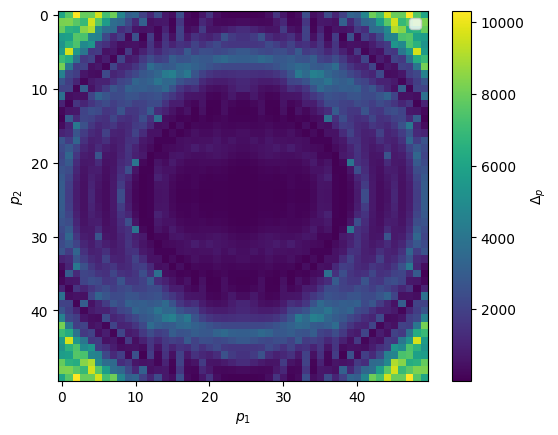


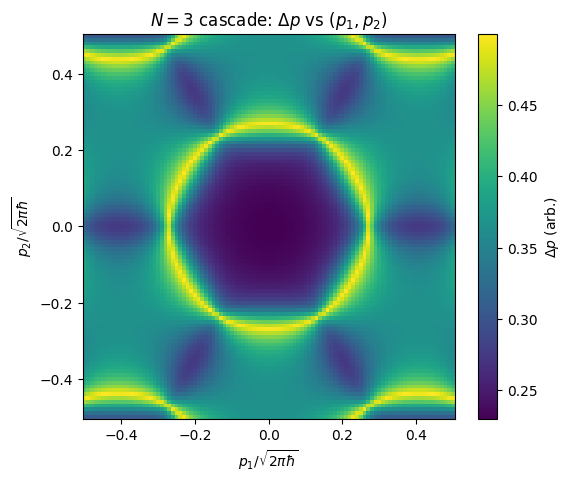

# Kaleidoscope

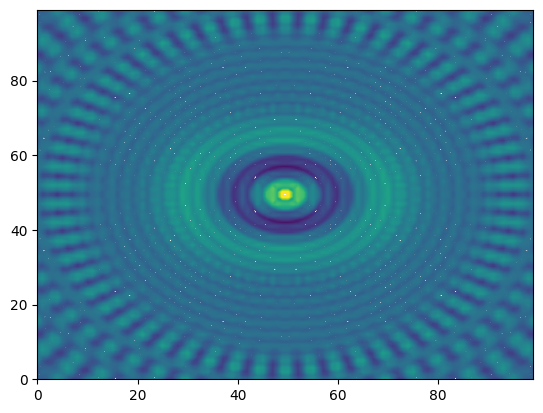